In [1]:
pip install ultralytics opencv-python matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 535.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.9/871.9 kB 8.8 MB/s eta 0:00:00


100%|██████████| 83.7M/83.7M [00:00<00:00, 225MB/s]


Enter the image URL: https://i.pinimg.com/564x/b8/8c/7c/b88c7c29d2da22ef603e409bd5afeeec.jpg

0: 640x480 1 person, 1 tie, 2628.8ms
Speed: 17.5ms preprocess, 2628.8ms inference, 38.8ms postprocess per image at shape (1, 3, 640, 480)
Model Inference Time: 6.7409 seconds
Enter the red value (0-255): 255
Enter the green value (0-255): 0
Enter the blue value (0-255): 0
Enter a key to store the RGB values: Kishore
RGB values for key 'Kishore' saved successfully to key_rgb_values.json


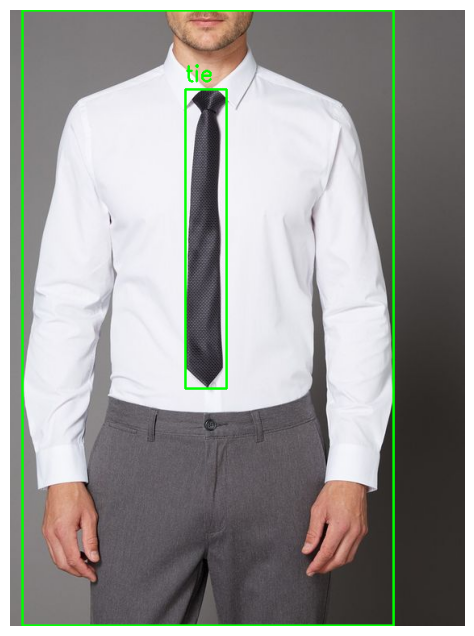

Select the tag to color from the detected objects {'tie', 'person'}: tie


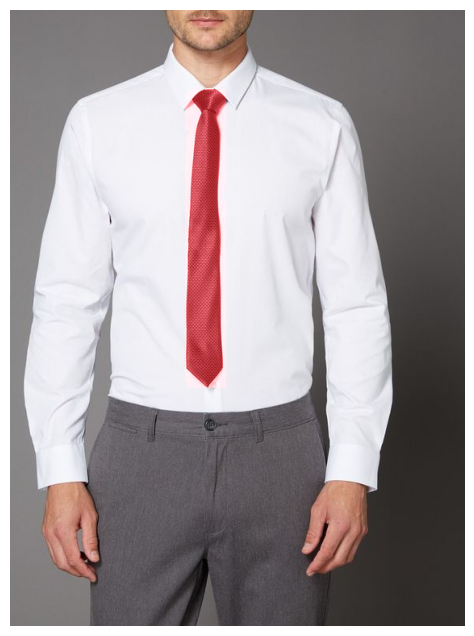

Output image saved as output_image.jpg
Processing Time: 0.3427 seconds
Total Execution Time: 29.3812 seconds


In [2]:
import time
from ultralytics import YOLO
import cv2
import numpy as np
from matplotlib import pyplot as plt
from urllib.request import urlretrieve
import json


startTime = time.time()


model = YOLO('yolov8l.pt')# Load the YOLOv8 model


inputImage_url = input("Enter the image URL: ")# Get the URL of the Image
inputImage_path = 'input_image.jpg'
urlretrieve(inputImage_url, inputImage_path)


image = cv2.imread(inputImage_path)# Read the input image with OpenCV
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform inference
inference_start = time.time()
results = model.predict(image_rgb)
inference_end = time.time()

inference_duration = inference_end - inference_start
print(f"Model Inference Time: {inference_duration:.4f} seconds")


r_value = int(input("Enter the red value (0-255): "))# Get the RGB Values to be filled
g_value = int(input("Enter the green value (0-255): "))
b_value = int(input("Enter the blue value (0-255): "))


rgb_key = input("Enter a key to store the RGB values: ")# Get a key to store the RGB values

# Define a function to save RGB values to a local file
def saveRGBKeytoFile(key, r, g, b, filename='key_rgb_values.json'):
    rgb_data = {}

    # Try to read the existing data, if the file exists
    try:
        with open(filename, 'r') as file:
            rgb_data = json.load(file)
    except FileNotFoundError:
        pass

    # Store the new RGB values against the key
    rgb_data[key] = {'red': r, 'green': g, 'blue': b}

    # Write the updated data back to the file
    with open(filename, 'w') as file:
        json.dump(rgb_data, file, indent=4)

    print(f"RGB values for key '{key}' saved successfully to {filename}")

# Save the RGB values to a file
saveRGBKeytoFile(rgb_key, r_value, g_value, b_value)

# Define the function to fill the area with a custom color using Sobel edge detection
def fillRegionWithColor(crop, b_value, g_value, r_value):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Sobel edge detection
    sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)  # Sobel in x-direction
    sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)  # Sobel in y-direction

    sobel_combined = cv2.magnitude(sobel_x, sobel_y) # Combine the x and y direction Sobel results
    sobel_combined = np.uint8(np.absolute(sobel_combined))  # Convert to uint8

    _, edges = cv2.threshold(sobel_combined, 50, 255, cv2.THRESH_BINARY) # Threshold the result to get a binary edge map


    kernel = np.ones((5, 5), np.uint8)# Dilate the edges to close small gaps
    dilated_edges = cv2.dilate(edges, kernel, iterations=2)

    # Find contours from the dilated edges
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(crop.shape[:2], dtype=np.uint8) # Create a mask for the contours

    for contour in contours:
        if cv2.contourArea(contour) > 1000:
            cv2.drawContours(mask, [contour], 0, 255, -1)

    custom_overlay = np.zeros_like(crop)# Create a custom color overlay based on user input
    custom_overlay[:] = (b_value, g_value, r_value)  # BGR color format

    custom_filled_area = cv2.bitwise_and(custom_overlay, custom_overlay, mask=mask)

    # Combine the original image with the custom filled area
    result = cv2.addWeighted(crop, 1, custom_filled_area, 0.5, 0)
    return result

# Creating a copy of the original image
final_image = image.copy()


class_names_detected = []# Display detected objects and store class names for user input
for result in results:
    for box in result.boxes:
        class_name = result.names[int(box.cls)]
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        class_names_detected.append(class_name)


        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw bounding box (green) and put class name on the display image
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


image_rgb_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# Display the image with bounding boxes and class tags
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb_display)
plt.axis('off')
plt.show()

# Add a 5-second delay before asking for the object to be selected, This is because the plt.show is taking some time to display the image
time.sleep(5)

#  Ask the user to select the tag after displaying the image
selected_tag = input(f"Select the tag to color from the detected objects {set(class_names_detected)}: ")

# Process detected objects again to fill selected area
processing_start = time.time()
for result in results:
    for box in result.boxes:
        class_name = result.names[int(box.cls)]
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        if class_name.lower() == selected_tag.lower():
            # Crop the detected region from the final image (without boxes)
            crop = final_image[y1:y2, x1:x2]

            # Fill the area with custom color using Canny detector
            filled_crop = fillRegionWithColor(crop, b_value, g_value, r_value)

            # Replace the cropped region in the final image (without boxes)
            final_image[y1:y2, x1:x2] = filled_crop

# Convert to RGB for displaying with matplotlib
final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

# Display the final image with the filled area and no bounding boxes or tags
plt.figure(figsize=(12, 8))
plt.imshow(final_image_rgb)
plt.axis('off')
plt.show()

# Save the output image without green boxes and labels
output_image_path = 'output_image.jpg'
cv2.imwrite(output_image_path, final_image)

processing_end = time.time()
processing_duration = processing_end - processing_start
total_duration = time.time() - startTime

# Print performance results
print(f"Output image saved as {output_image_path}")
print(f"Processing Time: {processing_duration:.4f} seconds")
print(f"Total Execution Time: {total_duration:.4f} seconds")


Enter the image URL: https://i.pinimg.com/564x/b8/8c/7c/b88c7c29d2da22ef603e409bd5afeeec.jpg

0: 640x480 1 person, 1 tie, 3191.3ms
Speed: 9.0ms preprocess, 3191.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)
Model Inference Time: 5.4531 seconds
Enter the red value (0-255): 255
Enter the green value (0-255): 0
Enter the blue value (0-255): 0
Enter a key to store the RGB values: Kishore
RGB values for key 'Kishore' saved successfully to key_rgb_values.json


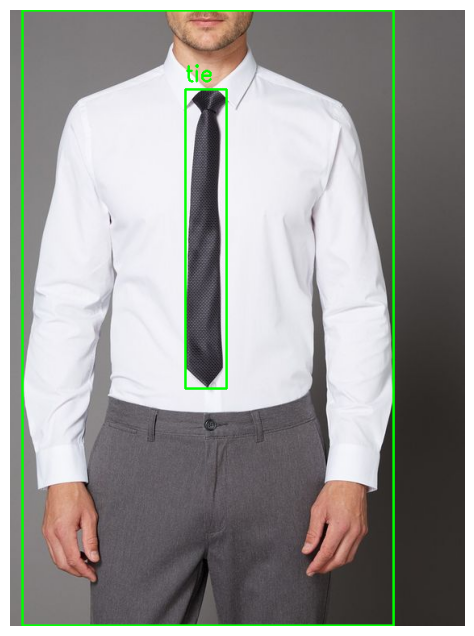

Select the tag to color from the detected objects {'tie', 'person'}: tie


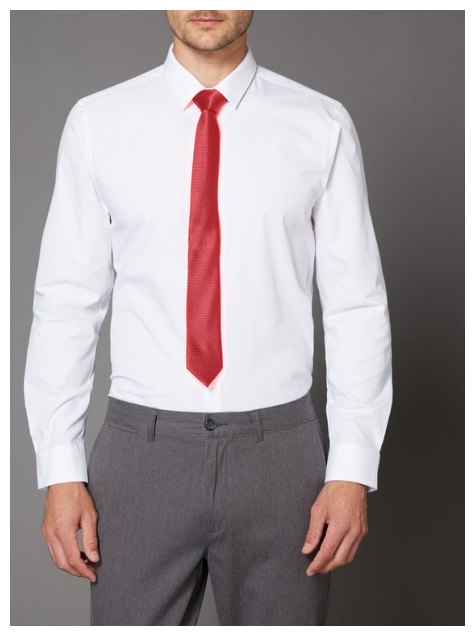

Output image saved as output_image.jpg
Processing Time: 0.2768 seconds
Total Execution Time: 52.1962 seconds


In [3]:
import time
from ultralytics import YOLO
import cv2
import numpy as np
from matplotlib import pyplot as plt
from urllib.request import urlretrieve
import json


startTime = time.time()


model = YOLO('yolov8l.pt')# Load the YOLOv8 model


inputImage_url = input("Enter the image URL: ")# Get the URL of the Image
inputImage_path = 'input_image.jpg'
urlretrieve(inputImage_url, inputImage_path)


image = cv2.imread(inputImage_path)# Read the input image with OpenCV
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


inference_start = time.time()# Perform inference
results = model.predict(image_rgb)
inference_end = time.time()

inference_duration = inference_end - inference_start
print(f"Model Inference Time: {inference_duration:.4f} seconds")


r_value = int(input("Enter the red value (0-255): "))# Get the RGB Values to be filled
g_value = int(input("Enter the green value (0-255): "))
b_value = int(input("Enter the blue value (0-255): "))


rgb_key = input("Enter a key to store the RGB values: ")# Get a key to store the RGB values


def saveRGBKeytoFile(key, r, g, b, filename='key_rgb_values.json'):# Define a function to save RGB values to a local file
    rgb_data = {}

    # Try to read the existing data, if the file exists
    try:
        with open(filename, 'r') as file:
            rgb_data = json.load(file)
    except FileNotFoundError:
        pass

    # Store the new RGB values against the key
    rgb_data[key] = {'red': r, 'green': g, 'blue': b}

    # Write the updated data back to the file
    with open(filename, 'w') as file:
        json.dump(rgb_data, file, indent=4)

    print(f"RGB values for key '{key}' saved successfully to {filename}")

# Save the RGB values to a file
saveRGBKeytoFile(rgb_key, r_value, g_value, b_value)

# Define the function to fill the area with a custom color using Prewitt edge detection

def fillRegionWithColor(crop, b_value, g_value, r_value):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Prewitt edge detection
    kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float64)  # Prewitt in x-direction
    kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=np.float64)  # Prewitt in y-direction

    prewitt_x = cv2.filter2D(blurred, cv2.CV_64F, kernel_x)  # Apply Prewitt filter in x-direction
    prewitt_y = cv2.filter2D(blurred, cv2.CV_64F, kernel_y)  # Apply Prewitt filter in y-direction
    prewitt_combined = np.sqrt(prewitt_x**2 + prewitt_y**2)# Combine the x and y direction Prewitt results
    prewitt_combined = np.uint8(np.absolute(prewitt_combined))  # Convert to uint8

    _, edges = cv2.threshold(prewitt_combined, 50, 255, cv2.THRESH_BINARY) # Threshold the result to get a binary edge map


    kernel = np.ones((5, 5), np.uint8) # Dilate the edges to close small gaps
    dilated_edges = cv2.dilate(edges, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    mask = np.zeros(crop.shape[:2], dtype=np.uint8) # Create a mask for the contours


    for contour in contours:
        if cv2.contourArea(contour) > 1000:
            cv2.drawContours(mask, [contour], 0, 255, -1)


    custom_overlay = np.zeros_like(crop) # Create a custom color overlay based on user input
    custom_overlay[:] = (b_value, g_value, r_value)  # BGR color format
    custom_filled_area = cv2.bitwise_and(custom_overlay, custom_overlay, mask=mask) # Apply the mask to the custom color overlay


    result = cv2.addWeighted(crop, 1, custom_filled_area, 0.5, 0) # Combine the original image with the custom filled area
    return result


# Creating a copy of the original image
final_image = image.copy()

# Display detected objects and store class names for user input
class_names_detected = []
for result in results:
    for box in result.boxes:
        class_name = result.names[int(box.cls)]
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        class_names_detected.append(class_name)

        # Draw bounding box (green) and put class name on the display image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with bounding boxes and class tags
image_rgb_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb_display)
plt.axis('off')
plt.show()

# Add a 5-second delay before asking for the object to be selected
time.sleep(5)


selected_tag = input(f"Select the tag to color from the detected objects {set(class_names_detected)}: ")#  Ask the user to select the tag after displaying the image


processing_start = time.time()# Process detected objects again to fill selected area
for result in results:
    for box in result.boxes:
        class_name = result.names[int(box.cls)]
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        if class_name.lower() == selected_tag.lower():
            # Crop the detected region from the final image (without boxes)
            crop = final_image[y1:y2, x1:x2]

            # Fill the area with custom color using Prewitt detector
            filled_crop = fillRegionWithColor(crop, b_value, g_value, r_value)

            # Replace the cropped region in the final image (without boxes)
            final_image[y1:y2, x1:x2] = filled_crop

# Convert to RGB for displaying with matplotlib
final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

# Display the final image with the filled area and no bounding boxes or tags
plt.figure(figsize=(12, 8))
plt.imshow(final_image_rgb)
plt.axis('off')
plt.show()

# Save the output image without green boxes and labels
output_image_path = 'output_image.jpg'
cv2.imwrite(output_image_path, final_image)

processing_end = time.time()
processing_duration = processing_end - processing_start
total_duration = time.time() - startTime

# Print performance results
print(f"Output image saved as {output_image_path}")
print(f"Processing Time: {processing_duration:.4f} seconds")
print(f"Total Execution Time: {total_duration:.4f} seconds")
